# Previsão de churn

## Importando os pacotes

In [21]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split

from imblearn.over_sampling import RandomOverSampler
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import (AdaBoostClassifier,
ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier)
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier, train

from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report

## Lendo os dados

In [22]:
train_df = pd.read_csv('treino.csv', index_col = 0)
test_df = pd.read_csv('teste.csv', index_col = 0)

In [23]:
train_df.shape

(8000, 13)

In [24]:
test_df.shape

(2000, 13)

In [25]:
df = pd.concat([train_df, test_df], ignore_index=True)

In [26]:
df.shape

(10000, 13)

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           10000 non-null  int64  
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 1015.8+ KB


In [28]:
df.select_dtypes(include="float64").columns

Index(['Balance', 'EstimatedSalary'], dtype='object')

In [29]:
# Verificar os saldos zerados e se eles podem ser removidos do dataset 
df.isnull().sum()

CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [30]:
df.describe(percentiles =[0.01, 0.1, 1,.35, .25, .75, .90, .99])

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
1%,1.556851e+07,432.000000,21.000000,0.000000,0.000000,1.000000,0.00000,0.000000,1842.825300,0.000000
10%,1.559117e+07,521.000000,27.000000,1.000000,0.000000,1.000000,0.00000,0.000000,20273.580000,0.000000
25%,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
35%,1.565414e+07,613.000000,34.000000,3.000000,0.000000,1.000000,1.00000,0.000000,70659.728000,0.000000
50%,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000


In [31]:
df.describe(include="object")

,Surname,Geography,Gender
count,10000,10000,10000
unique,2932,3,2
top,Smith,France,Male
freq,32,5014,5457


#### Analisar o dataset como um todo: 
- Quantos dados faltantes existem nesse dataset?
- Quantos dados nulos possui?
- Quantos dados duplicados possue?


In [32]:
train_df.isnull().sum(axis=0)

CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [33]:
# Verificando a porcentagem de dados faltantes por colunas 
pd.DataFrame(train_df.isnull().sum(axis=0)).sort_values(by=0, ascending=False)/train_df.shape[0]*100

,0
CustomerId,0.0
Surname,0.0
CreditScore,0.0
Geography,0.0
Gender,0.0
Age,0.0
Tenure,0.0
Balance,0.0
NumOfProducts,0.0
HasCrCard,0.0


In [34]:
df.duplicated().sum()

0       False
1       False
2       False
3       False
4       False
        ...  
9995    False
9996    False
9997    False
9998    False
9999    False
Length: 10000, dtype: bool

In [35]:
df.nunique()

CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

Aparentemente o dataset está completo com todos os campos preenchidos com dados. Então, deve-se se olhar um pouco sobre esse dataset

Na coluna de Balance (Saldo) há alguns valores que constam como zerados, vamos descobrir quantos dados zerados há? 

In [36]:
train_df.value_counts(['Balance'])

Balance  
0.00         2918
105473.74       2
132164.26       1
132129.72       1
132122.42       1
             ... 
106870.12       1
106854.21       1
106831.69       1
106819.65       1
250898.09       1
Length: 5082, dtype: int64

In [37]:
train_df['Balance'].value_counts(normalize=True)*100

0.00         36.4750
105473.74     0.0250
83036.05      0.0125
160426.07     0.0125
114346.30     0.0125
              ...   
124662.54     0.0125
88324.31      0.0125
132591.36     0.0125
128808.65     0.0125
152390.26     0.0125
Name: Balance, Length: 5082, dtype: float64

De 8.000 dados existentes na coluna de Balance 2918, que de acordo com o Código representa 36,4% do dataset. 

In [38]:
train_df["Balance"].describe(percentiles=[.01, .1, .25, .5, .75, .9, .999])

count      8000.000000
mean      76102.139645
std       62461.005757
min           0.000000
1%            0.000000
10%           0.000000
25%           0.000000
50%       96447.520000
75%      127611.332500
90%      149299.326000
99.9%    212692.973350
max      250898.090000
Name: Balance, dtype: float64

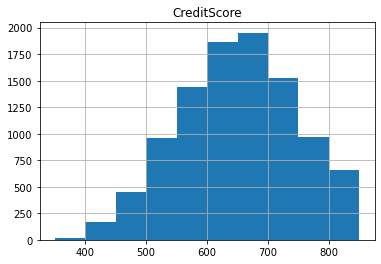

<Figure size 432x288 with 0 Axes>

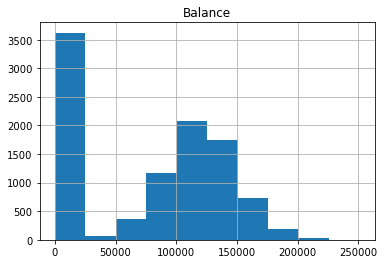

<Figure size 432x288 with 0 Axes>

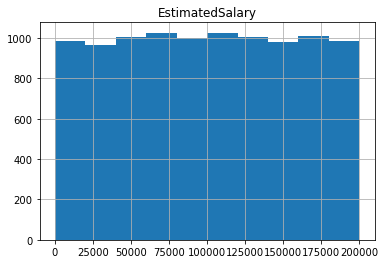

<Figure size 432x288 with 0 Axes>

In [39]:
cont = df[["CreditScore", "Balance", "EstimatedSalary"]]

for i in cont.columns:
    cont[cont.columns].hist(i)
    plt.figure()

### Sugestão de roteiro de análise: 

#### Analisar cada variáveis separadamente: 
- Qual o sexo mais frequente no conjunto de treinamento? 
- Qual a proporção entre as pessoas que saíram e ficaram (Exited 1 e 0)
- Qual a idade mais frequente no conjunto de treinamento? 
- Qual a renda media no conjunto de treimento? 
- Quantos produtos os clientes tem em média? 
- Quantos países diferentes temos clientes?
- ...





In [40]:
# Qual o sexo mais frequente no conjunto?
data_gender = train_df.value_counts(['Gender'])
data_gender

Gender
Male      4362
Female    3638
dtype: int64

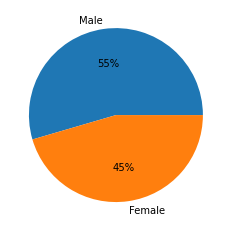

In [41]:
# plotar gráfico de pizza

data = [data_gender]
labels = ['Male', 'Female']

#define Seaborn color palette to use
colors = sns.color_palette()[0:5] 

#create pie chart
plt.pie(data_gender, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

In [42]:
# Qual a proporção entre as pessoas que saíram e ficaram (Exited 1 e 0)
data1 = train_df['Exited'].value_counts(normalize=True)*100
data1

0    79.45
1    20.55
Name: Exited, dtype: float64

In [43]:
# Qual a idade mais frequente no conjunto de treinamento? = moda
df['Age'].mode()

0    37
dtype: int64

In [44]:
# Qual a renda media no conjunto de treimento?
train_df.mean()['EstimatedSalary']

100431.28976374975

In [45]:
# Quantos produtos os clientes tem em média?
train_df['NumOfProducts'].mean()

1.531375

Essa é uma coluna muito interessante para se trabalhar! ['NumOfProdcuts']

In [46]:
# Quantos países diferentes temos clientes?
train_df['Geography'].unique()

array(['France', 'Germany', 'Spain'], dtype=object)

#### Analisar varíaveis com relação as outras variáveis
- Pessoas mais velhas tem remuneração média maior maior?
- Pessoas mais velhas tem maior tendencia a ter cartão de credito? 
- Existe algum país com remuneração média maior? 
- ...

In [47]:
df.corr()

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
CustomerId,1.000000,0.005308,0.009497,-0.014883,-0.012419,0.016972,-0.014025,0.001665,0.015271,-0.006248
CreditScore,0.005308,1.000000,-0.003965,0.000842,0.006268,0.012238,-0.005458,0.025651,-0.001384,-0.027094
Age,0.009497,-0.003965,1.000000,-0.009997,0.028308,-0.030680,-0.011721,0.085472,-0.007201,0.285323
Tenure,-0.014883,0.000842,-0.009997,1.000000,-0.012254,0.013444,0.022583,-0.028362,0.007784,-0.014001
Balance,-0.012419,0.006268,0.028308,-0.012254,1.000000,-0.304180,-0.014858,-0.010084,0.012797,0.118533
NumOfProducts,0.016972,0.012238,-0.030680,0.013444,-0.304180,1.000000,0.003183,0.009612,0.014204,-0.047820
HasCrCard,-0.014025,-0.005458,-0.011721,0.022583,-0.014858,0.003183,1.000000,-0.011866,-0.009933,-0.007138
IsActiveMember,0.001665,0.025651,0.085472,-0.028362,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.156128
EstimatedSalary,0.015271,-0.001384,-0.007201,0.007784,0.012797,0.014204,-0.009933,-0.011421,1.000000,0.012097
Exited,-0.006248,-0.027094,0.285323,-0.014001,0.118533,-0.047820,-0.007138,-0.156128,0.012097,1.000000


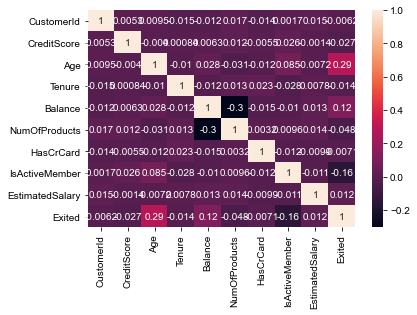

In [48]:
# plot um gráfico heatmap aqui!
sns.heatmap(df.corr(), annot= True)
sns.set(rc={'figure.figsize':(18,16)})

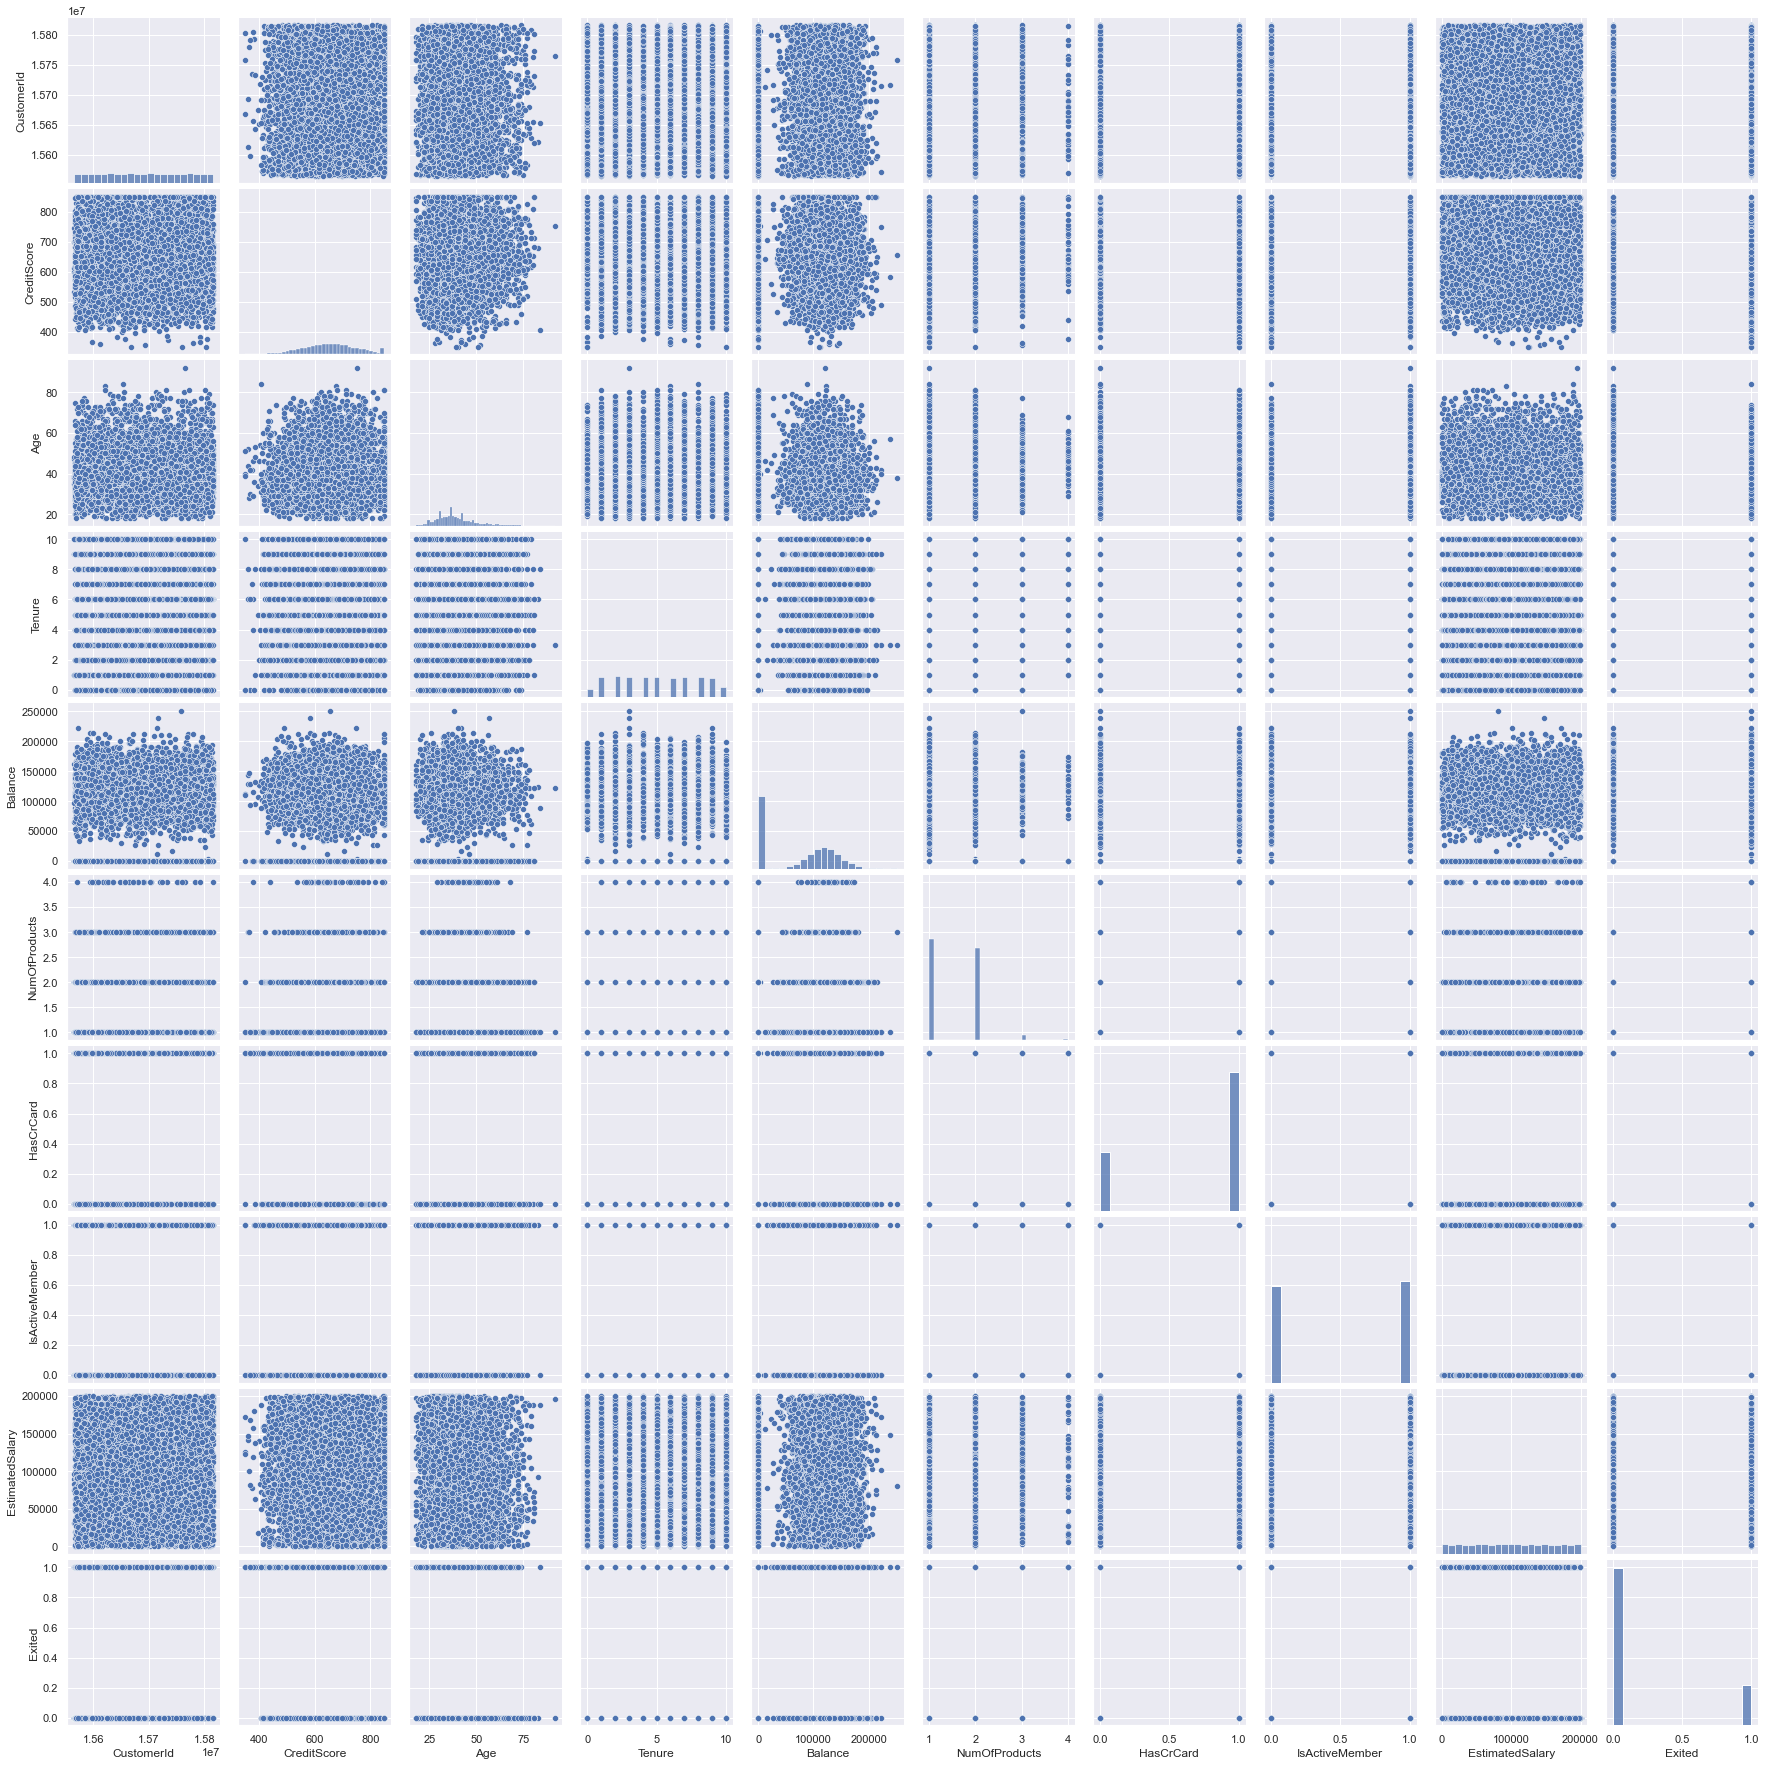

In [49]:
sns.pairplot(train_df) 

<AxesSubplot:ylabel='Frequency'>

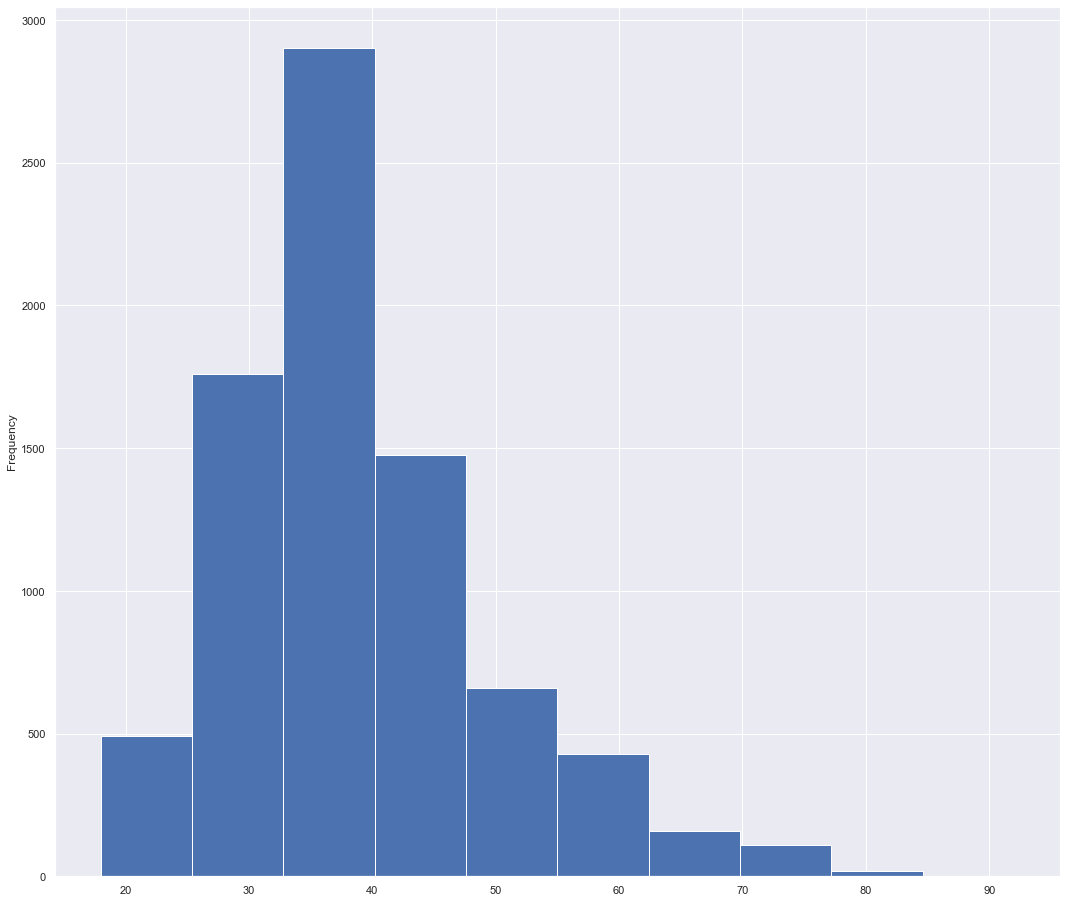

In [50]:
# Visualizando a distribuição da coluna idade
train_df['Age'].plot(kind = 'hist')

In [51]:
df['AgeGroup'] = df['Age'].apply(lambda x: 'Senior' if x >=55  else 'Adult')
df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,AgeGroup
0,15601116,P'an,686,France,Male,32,6,0.00,2,1,1,179093.26,0,Adult
1,15766374,Leak,632,Germany,Male,42,4,119624.60,2,1,1,195978.86,0,Adult
2,15716994,Green,559,Spain,Male,24,3,114739.92,1,1,0,85891.02,1,Adult
3,15730759,Chukwudi,561,France,Female,27,9,135637.00,1,1,0,153080.40,1,Adult
4,15797900,Chinomso,517,France,Male,56,9,142147.32,1,0,0,39488.04,1,Senior


In [52]:
# Pessoas mais velhas tem remuneração média maior maior?  S/N 
# 1. Criar coluna e agrupar os clientes por idadae e depois executar .mean() em cada categoria
df["AgeCategory"] = 'Adult'
df.loc[df['Age'] >= 55, 'AgeCategory'] ='Senior'
df.loc[df['Age'] <= 25, 'AgeCategory'] = 'Young'
display(df)

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,AgeGroup,AgeCategory
0,15601116,P'an,686,France,Male,32,6,0.00,2,1,1,179093.26,0,Adult,Adult
1,15766374,Leak,632,Germany,Male,42,4,119624.60,2,1,1,195978.86,0,Adult,Adult
2,15716994,Green,559,Spain,Male,24,3,114739.92,1,1,0,85891.02,1,Adult,Young
3,15730759,Chukwudi,561,France,Female,27,9,135637.00,1,1,0,153080.40,1,Adult,Adult
4,15797900,Chinomso,517,France,Male,56,9,142147.32,1,0,0,39488.04,1,Senior,Senior
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,15598982,Klein,602,Germany,Female,53,5,98268.84,1,0,1,45038.29,1,Adult,Adult
9996,15572631,Ndubuisi,609,France,Male,25,10,0.00,1,0,1,109895.16,0,Adult,Young
9997,15746674,Miller,730,France,Female,47,7,0.00,1,1,0,33373.26,1,Adult,Adult
9998,15689081,Wu,692,France,Male,29,4,0.00,1,1,0,76755.99,1,Adult,Adult


In [53]:
df.value_counts(['AgeCategory'])

AgeCategory
Adult          8507
Senior          882
Young           611
dtype: int64

In [54]:
# 2. pessoas mais velhas tendem a ter uma méida maior? 
df.groupby('AgeCategory')['EstimatedSalary'].mean()

AgeCategory
Adult     100410.160699
Senior     95616.542449
Young     102093.897381
Name: EstimatedSalary, dtype: float64

In [55]:
# Pessoas mais velhas tem maior tendencia a ter cartão de credito? S/N
df.groupby('AgeCategory')['HasCrCard'].mean()*100

AgeCategory
Adult     70.588927
Senior    70.748299
Young     69.721768
Name: HasCrCard, dtype: float64

In [56]:
# Existe algum país com remuneração média maior? — Group by mean Geography
# df.groupby('A')['B'].mean()
df.groupby('Geography')['EstimatedSalary'].mean()

Geography
France      99899.180814
Germany    101113.435102
Spain       99440.572281
Name: EstimatedSalary, dtype: float64

# Analisar cada variável com relação ao target: 
- Existe alguma faixa etária com maior proporção de clientes que saíram? 
- Existe algum sexo com a maior proporção de clientes que saíram? 
- Existe algum país com a maior proporçào de clientes que saíram? 
- ...
**Use sua criativiade para realizar as análises!**
> *Variavel Target = Exited* <br>


In [57]:
# Existe alguma faixa etária com maior proporção de clientes que saíram?
df.groupby('AgeCategory')['Exited'].mean()*100

AgeCategory
Adult     19.384037
Senior    38.775510
Young      7.528642
Name: Exited, dtype: float64

In [58]:
# Existe algum sexo com a maior proporção de clientes que saíram?
df.groupby('Gender')["Exited"].mean()*100

Gender
Female    25.071539
Male      16.455928
Name: Exited, dtype: float64

In [59]:
# Existe algum país com a maior proporçào de clientes que saíram?
df.groupby('Geography')["Exited"].mean()*100

Geography
France     16.154767
Germany    32.443204
Spain      16.673395
Name: Exited, dtype: float64

In [60]:
# Analisar a coluna Produtcs em relação ao Exited
df.groupby('NumOfProducts')['Exited'].mean()*100

NumOfProducts
1     27.714398
2      7.581699
3     82.706767
4    100.000000
Name: Exited, dtype: float64

In [61]:
df["CreditScore"].describe(percentiles=[.001, .01, .1, .25,.35, .5, .75, .9, .999])

count    10000.000000
mean       650.528800
std         96.653299
min        350.000000
0.1%       366.998000
1%         432.000000
10%        521.000000
25%        584.000000
35%        613.000000
50%        652.000000
75%        718.000000
90%        778.000000
99.9%      850.000000
max        850.000000
Name: CreditScore, dtype: float64

<AxesSubplot:ylabel='Frequency'>

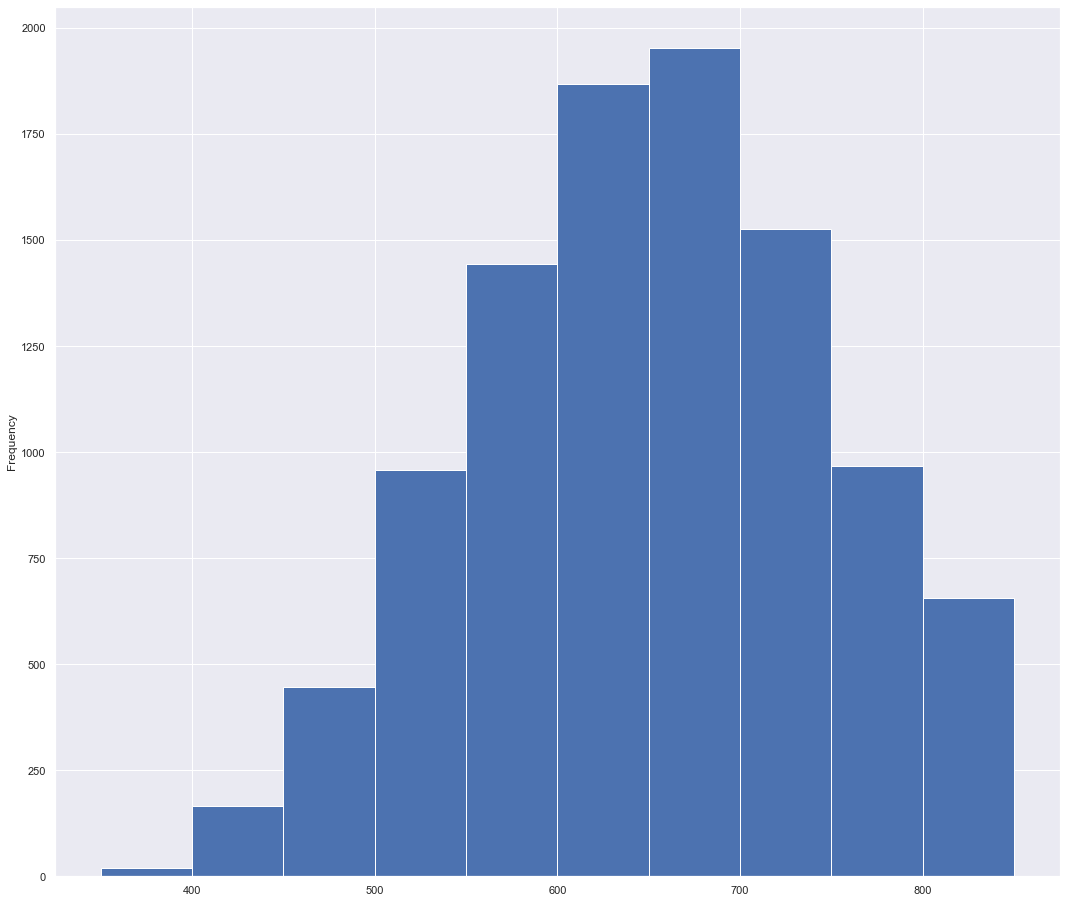

In [62]:
df['CreditScore'].plot(kind = 'hist')

In [63]:
df.columns

Index(['CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age',
       'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
       'EstimatedSalary', 'Exited', 'AgeGroup', 'AgeCategory'],
      dtype='object')

<h1> Conclusões da Análise Exploratória </h1>

# Transformando Variáveis

## Treinando o Modelo

### Criando o set de treinamento

In [89]:
df['Gender']= df['Gender'].map({'Male':0, 'Female':1})
df['AgeCategory']= df['AgeCategory'].map({'Adult':0, 'Senior':1, 'Young':2})
#clientes['aprovacao_emprestimo']= clientes['aprovacao_emprestimo'].map({'N':0, 'Y':1})

In [90]:
df1 = df[['CustomerId', 'Surname',"CreditScore", "Gender",
          "Tenure", "Balance", "NumOfProducts", "HasCrCard", "IsActiveMember", "EstimatedSalary", "Exited", 
          "AgeCategory", "Geography_France", "Geography_Germany", "Geography_Spain"]]
df1.head()

,CustomerId,Surname,CreditScore,Gender,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,AgeCategory,Geography_France,Geography_Germany,Geography_Spain
0,15601116,P'an,686,NaN,6,0.00,2,1,1,179093.26,0,NaN,1,0,0
1,15766374,Leak,632,NaN,4,119624.60,2,1,1,195978.86,0,NaN,0,1,0
2,15716994,Green,559,NaN,3,114739.92,1,1,0,85891.02,1,NaN,0,0,1
3,15730759,Chukwudi,561,NaN,9,135637.00,1,1,0,153080.40,1,NaN,1,0,0
4,15797900,Chinomso,517,NaN,9,142147.32,1,0,0,39488.04,1,NaN,1,0,0


In [91]:
df = pd.get_dummies(df, columns=['Geography'])

KeyError: "None of [Index(['Geography'], dtype='object')] are in the [columns]"

In [81]:
y = df1['Exited']
X = df1.drop(['CustomerId', 'Surname', 'Exited'], axis = 1)

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Tratando as variáveis numéricas

In [ ]:
scaler = StandardScaler()

In [ ]:
variaveis_scalling = ['CreditScore', 'EstimatedSalary', 'Balance']

In [ ]:
#Lembrar: uso o metodo fit_transform nos dados de treinamento e transform nos dados de teste/predição! 
X[variaveis_scalling] = scaler.fit_transform(X[variaveis_scalling])

# Tratando as variáveis categoricas

 * Aplicar map e One Hot Coding 

In [ ]:
#Lembrar: uso o metodo fit_transform nos dados de treinamento e transform nos dados de teste/predição! 
X_train[variaveis_categoricas] = label_encoder.fit_transform(X_train[variaveis_categoricas])

### Tratando o desbalanceamento entre as classes

In [ ]:
from imblearn.over_sampling import RandomOverSampler

In [ ]:
#Lembrete só aplica over/under sampling nos dados de treinamento
sampling = RandomOverSampler()

In [ ]:
X_train_sampled, y_train_sampled = sampling.fit_resample(X_train, y_train)

### Treinamento do modelo

In [ ]:
model =GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0)

In [ ]:
X_train

In [ ]:
model.fit(X_train, y_train)

### Sugestao de roteiro de modelagem
- Testar varios tipos de modelo: DecisionTree, RandomForest, SVM, XGboost,...
- Testar varios hiperparametros no modelo: GridSearch, RandomSearch,... 
- Aplicar AutoML: Tpot 
- Testar varios formas de categorical encoder: OneHotEncoding, CatboostEncoding, ...
- Testar varios formas de Scalling de features numericas: MinMaxScaler, AbsScaler ...
- Criar novas features a partir das atuais: Dividir idade em faixa etaria, Dividir renda em faixa
- Testar varios conjuntos de features: Excluir features menos importantes, Recursive Feature Elimination

### Links uteis

- https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html
- https://www.scikit-yb.org/en/latest/quickstart.html
- https://imbalanced-learn.org/stable/references/over_sampling.html
- https://scikit-learn.org/stable/modules/preprocessing.html
- https://contrib.scikit-learn.org/category_encoders


Provavelmente a alteração do Recall se dá pela não remoção de outliers. É necessário rever o dataset e a análise Exploratória dos dados para tentar aumentar a taxa de Recall.  

## Avaliando o modelo

### Tratando os dados de teste

In [ ]:
y_test = test_df['Exited']
X_test = test_df.drop(['CustomerId', 'Surname', 'Exited'], axis = 1)

In [ ]:
X_test[variaveis_scalling] = scaler.transform(X_test[variaveis_scalling])
X_test[variaveis_categoricas] = label_encoder.transform(X_test[variaveis_categoricas])

### Realizando a predição

In [ ]:
y_pred = model.predict(X_test)

### Calculando as metricas

In [ ]:
confusion_matrix(y_pred= y_pred, y_true = y_test)

In [84]:
models = {
        'RandomForestClassifier':    RandomForestClassifier(n_estimators=200, max_depth=2), 
        'ExtraTreeClassifier':       ExtraTreesClassifier(n_estimators=100, random_state=0),
        'DecisionTreeClassifier':     DecisionTreeClassifier(criterion="entropy"), 
        'AdaBoostClassifier':         AdaBoostClassifier(n_estimators=100, random_state=0),
        'GradientBoostingClassifier': GradientBoostingClassifier(), 
        'RedesNeurais':               MLPClassifier(hidden_layer_sizes=(100, 50, 10), max_iter=1000)
         } 

for reg, modelo in zip(models.values(),models.keys()):
  regressor = reg
  regressor.fit(X_train, y_train)
  y_pred = regressor.predict(X_test)
  print(modelo)
  print(f"Acccuracy: {accuracy_score(y_test, y_pred)*100}%")
  print(f"Precision: {precision_score(y_test, y_pred)*100}%")
  print(f"Recall: {recall_score(y_test, y_pred)*100}%")
  print(f"F1: {f1_score(y_test, y_pred)*100}%")
  print('-----------------------------------')

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [ ]:
print(classification_report(y_pred= y_pred, y_true = y_test))

In [ ]:
def machine():
    #Modelos
    DTC = DecisionTreeClassifier(criterion="entropy")
    RFC = RandomForestClassifier(n_estimators=200, max_depth=3)
    EXT = ExtraTreesClassifier(n_estimators=100, random_state=0)
    XGB = XGBClassifier()
    ADA = AdaBoostClassifier(n_estimators=100, random_state=0)
    GBC = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0)
    MLP = MLPClassifier(hidden_layer_sizes=(100, 50, 10), max_iter=1000)

    #X/y and Spliting
    X = df#Pacient 
    X =df.drop('target', axis=1)
    y = df.target  # - TARGET
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    
    #Train
    DTC.fit(X_train,y_train)
    RFC.fit(X_train,y_train)
    EXT.fit(X_train,y_train)
    XGB.fit(X_train,y_train)
    ADA.fit(X_train,y_train)
    GBC.fit(X_train,y_train)
    MLP.fit(X_train,y_train)
    
    #Preds
    pred_DTC = DTC.predict(X_test)
    pred_RFC = RFC.predict(X_test)
    pred_EXT = EXT.predict(X_test)
    pred_XGB = XGB.predict(X_test)
    pred_ADA = ADA.predict(X_test)
    pred_GBC = GBC.predict(X_test)
    pred_MLP = MLP.predict(X_test)
    
    #Dic
    preds = {'pred_DTC':pred_DTC,
            'pred_RFC':pred_RFC,
            'pred_EXT': pred_EXT,
            'pred_XGB':pred_XGB,
            'pred_ADA': pred_ADA,
            'pred_GBC': pred_GBC,
            'pred_MLP':pred_MLP}
    
   #Accuracy
    acc_DTC = accuracy_score(y_test, pred_DTC)
    acc_RFC = accuracy_score(y_test, pred_RFC)
    acc_EXT = accuracy_score(y_test, pred_EXT)
    acc_XGB = accuracy_score(y_test, pred_XGB)
    acc_ADA = accuracy_score(y_test, pred_ADA)
    acc_GBC = accuracy_score(y_test, pred_GBC)
    acc_MLP = accuracy_score(y_test, pred_MLP)
    
    #Precision Score
    pcr_DTC = precision_score(y_test, pred_DTC)
    pcr_RFC = precision_score(y_test, pred_RFC)
    pcr_EXT = precision_score(y_test, pred_EXT)
    pcr_XGB = precision_score(y_test, pred_XGB)
    pcr_ADA = precision_score(y_test, pred_ADA)
    pcr_GBC = precision_score(y_test, pred_GBC)
    pcr_MLP = precision_score(y_test, pred_MLP)
    
    #Recall
    rcr_DTC = recall_score(y_test, pred_DTC)
    rcr_RFC = recall_score(y_test, pred_RFC)
    rcr_EXT = recall_score(y_test, pred_EXT)
    rcr_XGB = recall_score(y_test, pred_XGB)
    rcr_ADA = recall_score(y_test, pred_ADA)
    rcr_GBC = recall_score(y_test, pred_GBC)
    rcr_MLP = recall_score(y_test, pred_MLP)
    
    #F1 - Score
    fcr_DTC = f1_score(y_test, pred_DTC)
    fcr_RFC = f1_score(y_test, pred_RFC)
    fcr_EXT = f1_score(y_test, pred_EXT)
    fcr_XGB = f1_score(y_test, pred_XGB)
    fcr_ADA = f1_score(y_test, pred_ADA)
    fcr_GBC = f1_score(y_test, pred_GBC)
    fcr_MLP = f1_score(y_test, pred_MLP)

    
    accuracy = {'Decision Tree':acc_DTC*100,'Random Forest':acc_RFC*100,
              'Extra Tree':acc_EXT*100,'XGBoost': acc_XGB*100,'Ada Boost': acc_ADA*100, 
              'Gradient Boost': acc_GBC*100,'Redes Neurais':acc_MLP*100}
    
    precision = {'Decision Tree':pcr_DTC*100, 'Random Forest':pcr_RFC*100,
              'Extra Tree':pcr_EXT*100, 'XGBoost': pcr_XGB*100,'Ada Boost': pcr_ADA*100, 
              'Gradient Boost': pcr_GBC*100,'Redes Neurais':pcr_MLP*100}
    
    recall = {'Decision Tree':rcr_DTC*100,  'Random Forest':rcr_RFC*100,
              'Extra Tree':rcr_EXT*100,'XGBoost': rcr_XGB*100,'Ada Boost': rcr_ADA*100, 
              'Gradient Boost': pcr_GBC*100, 'Redes Neurais':rcr_MLP*100}
        
    f1score= {'Decision Tree':fcr_DTC*100,'Random Forest':fcr_RFC*100,
              'Extra Tree':fcr_EXT*100,'XGBoost': fcr_XGB*100, 'Ada Boost': fcr_ADA*100, 
              'Gradient Boost': fcr_GBC*100,'Redes Neurais':fcr_MLP*100}
    # DataFrame
    data=accuracy,precision, recall, f1score

    df_metrics = pd.DataFrame.from_dict(data=data)

    # Gráfico — Grafico de: 1º Colunas Coluna / 2º Empilhadas 
    fig, ax = plt.subplots(figsize=(30, 12))
    ax.plot(pred_DTC,label='Decsion Tree')
    ax.plot(pred_RFC,label='Random Forest')
    ax.plot(pred_EXT,label='Extra Tree')
    ax.plot(pred_XGB,label='XGBoost')
    ax.plot(pred_ADA,label='ADA')
    ax.plot(pred_GBC,label='GradientBoost', color="red")
    ax.plot(pred_MLP,label='Redes Neurais', color='pink')
    ax.plot(y_test.values,label='alvo',color='black')
    ax.set_title('Desempenho de Modelos de ML')
    ax.set(xlabel='Score', ylabel='Acuracidade')
    legend = ax.legend(loc='best', shadow=True, fontsize='x-large')
    #plt.bar(x = , y= , color='r') 
    # plt.bar(x, y2, bottom=y1, color='b')
    return df_metrics

In [ ]:
machine()

### Explorando a importancia das features na predição

In [ ]:
from yellowbrick.model_selection import FeatureImportances

In [ ]:
viz = FeatureImportances(model, relative=False)

# Fit and show the feature importances
viz.fit(X_test, y_test)
viz.show()

## Exportando o modelo

In [ ]:
modelo = {
'model': model,
'scaler': scaler, 
'variaveis_scalling' : variaveis_scalling,
'encoder': label_encoder, 
'variaveis_categoricas': variaveis_categoricas,
'features_modelo': list(X_train.columns)
}

In [ ]:
modelo

In [ ]:
import joblib

In [ ]:
joblib.dump(modelo, 'modelo.pickle')

In [ ]:
modelo = joblib.load('modelo.pickle')

In [ ]:
def predict(modelo, dataframe):
    dataframe[modelo['variaveis_scalling']] = modelo['scaler'].transform(dataframe[modelo['variaveis_scalling']])
    dataframe[modelo['variaveis_categoricas']] = modelo['encoder'].transform(dataframe[modelo['variaveis_categoricas']])
    dataframe['predicao'] = modelo['model'].predict(dataframe[modelo['features_modelo']])
    return dataframe

In [ ]:
predict(modelo, test_df)

In [ ]:
!pip freeze